## Predicting Crashes in Financial Markets - Logistic Regression
- Datasets: S&P500 (USA), Nikkei225 (Japan), SSE (Shanghai/China), HSI (Hong Kong), BSESN (India), SMI (Switzerland), BVSP (Brazil)
- Model: Logistic Regression
- Number of features: 16 (mean price change and volatility for different windows over past 252 days)
- Response variable: Crash within 1 / 3 / 6 months (0: no, 1: yes)
- Crash definition: Drawdown in 99.5% quantile

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from datetime import datetime, timedelta
from pylab import rcParams
import os
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
os.chdir('/home/roman/Documents/Projects/Bubbles/models')
from prepare_data_4h import DataLoader
from evaluate_results2 import EvaluateResults

In [2]:
import importlib
import evaluate_results2
importlib.reload(evaluate_results2)
from evaluate_results2 import EvaluateResults

In [3]:
# -------------------- Data preparation -------------------- #
os.chdir('/home/roman/Documents/Projects/Bubbles/data')
datasets_original = ['^GSPC.csv', '^N225.csv', 'SSE.csv','^HSI.csv', '^BSESN.csv',\
                     '^SSMI.csv', '^BVSP.csv']
dataset_names = ['S&P 500', 'N225', 'SSE', 'HSI', 'BSESN', 'SMI', 'BVSP']

# specify drawdown thresholds for crashes (determined in exploration.ipynb):
crash_thresholds = [-0.0936, -0.1101, -0.1269, -0.1470, -0.1703, -0.1106, -0.2344] # <-- Jacobsson
# crash_thresholds = [-0.1053, -0.1495, -0.1706, -0.2334, -0.1563, -0.1492, -0.2264] # <-- Sornette
months = [1, 3, 6]              # <-- predict if crash n months ahead (use: 1, 3 or 6)
data = DataLoader(datasets_original, dataset_names)
datasets_revised, crashes = data.get_data_revised(crash_thresholds)
dfs_x, dfs_y = data.get_dfs_xy(months=months)

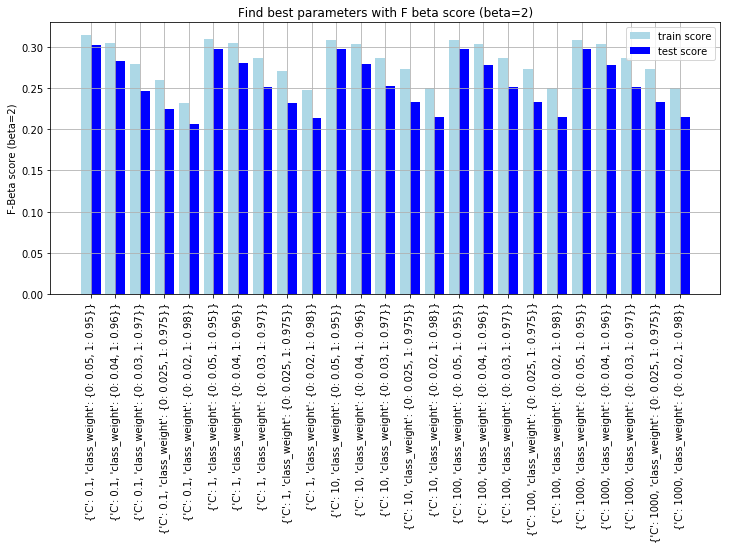

In [4]:
# -------------------- Find best parameters with grid search -------------------- #
model_name = 'Logistic Regression'
test_data = 'S&P 500'
month_prediction = 3
beta = 2

index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
x_train, y_train, _, _ = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=None)
y_train = y_train[:, index_month].astype(int)

# Find parameters with grid search:
fbeta_scorer = make_scorer(fbeta_score, beta=beta)
param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.05, 1:.95}, {0:.04, 1:.96}, \
               {0:.03, 1:.97}, {0:.025, 1:.975}, {0:.02, 1:.98}]}]   # <-- 1 month
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.07, 1:.93}, {0:.06, 1:.94}, \
#                 {0:.05, 1:.95}, {0:.04, 1:.96}]}]   # <-- 3 months
# param_grid = [{'C': [0.1, 1, 10, 100, 1000], 'class_weight': [{0:.11, 1:.89}, {0:.1, 1:.9},\
#                 {0:.09, 1:.91}, {0:.08, 1:.92}]}]   # <-- 6 months

clf = GridSearchCV(linear_model.LogisticRegression(penalty='l2'), param_grid, scoring=fbeta_scorer) 
model = clf.fit(x_train, y_train)
labels = model.cv_results_['params']
tr_score = model.cv_results_['mean_train_score']
t_score = model.cv_results_['mean_test_score']
rcParams['figure.figsize'] = 12, 5
plt.bar(x=np.arange(len(tr_score)) - 0.2,width=0.4, height=tr_score, color='lightblue', label='train score')
plt.bar(x=np.arange(len(t_score)) + 0.2,width=0.4, height=t_score, color='blue', label='test score')
plt.title('Find best parameters with F beta score (beta=2)')
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.ylabel('F-Beta score (beta=2)')
plt.legend()
plt.grid()
plt.show()

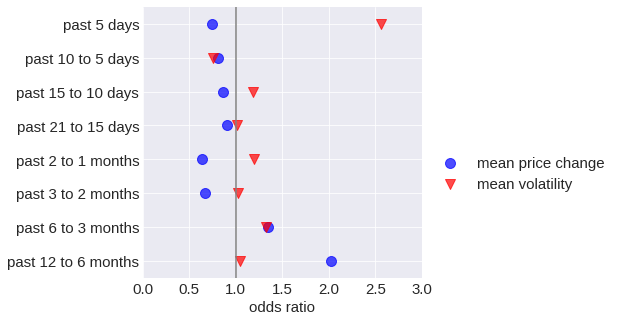

In [5]:
# -------------------- Logistic Regression coefficients-------------------- #
x_train, y_train, _, _ = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=None)
y_train = y_train[:, index_month].astype(int)
clf = linear_model.LogisticRegression(C=1, class_weight={0:.03, 1:.97})
model = clf.fit(x_train, y_train)
x_price_change = np.exp(model.coef_)[0][:8]
x_vol = np.exp(model.coef_)[0][8:]
y = np.arange(8)
labels = np.flip(['past 5 days','past 10 to 5 days',\
          'past 15 to 10 days','past 21 to 15 days',\
          'past 2 to 1 months','past 3 to 2 months',\
          'past 6 to 3 months','past 12 to 6 months'])
rcParams['figure.figsize'] = 5, 5
rcParams.update({'font.size': 15})
plt.style.use('seaborn-darkgrid')
plt.scatter(np.flip(x_price_change), y, marker='o', color='blue', s=100, alpha=0.7)
plt.scatter(np.flip(x_vol), y, marker='v', color='red', s=100, alpha=0.7)
plt.xlabel('odds ratio')
plt.legend(['mean price change', 'mean volatility'], loc='best', bbox_to_anchor=(1, 0.5))
plt.axvline(x=1, color='gray')
plt.xlim([0,3])
plt.yticks(range(8), labels)
plt.show()

In [6]:
# -------------------- Train Logistic Regression -------------------- #
class_weight = {0:.06, 1:.94}
C = 1
index_test = [i for i, name in enumerate(dataset_names) if name == test_data][0]
index_month = [i for i, m in enumerate(months) if m == month_prediction][0]
training_set_names = list(dataset_names)
training_set_names.pop(index_test)
dfs_x_training = list(dfs_x)
dfs_x_training.pop(index_test)
dfs_y_training = list(dfs_y)
dfs_y_training.pop(index_test)
y_train_all, y_test_all = [], []
y_pred_train_all, y_pred_test_all = [], []
for val_data in training_set_names:
    x_train, y_train, x_test, y_test = data.get_train_test(dfs_x_training, dfs_y_training, \
            training_set_names, test_data=val_data)
    y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
    y_train_all.append(y_train)
    y_test_all.append(y_test)
    print('Train ' + str(model_name) + ' - validation data: ' + str(val_data))
    clf = linear_model.LogisticRegression(C=C, class_weight=class_weight)
    model = clf.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_train_all.append(y_pred_train)
    y_pred_test = model.predict(x_test)
    y_pred_test_all.append(y_pred_test)

Train Logistic Regression - validation data: N225
Train Logistic Regression - validation data: SSE
Train Logistic Regression - validation data: HSI
Train Logistic Regression - validation data: BSESN
Train Logistic Regression - validation data: SMI
Train Logistic Regression - validation data: BVSP


In [7]:
# -------------------- Evaluate results -------------------- #
eval_ = EvaluateResults(y_train_all, y_test_all, y_pred_train_all, y_pred_test_all, model_name, test_data)
beta = 2
threshold = None
print(model_name)
print('\n')
print('Predict crash in:               ' + str(month_prediction) + ' months')
print('Threshold for positives:        ' + str(threshold))
print('Number of features:             ' + str(dfs_x[0].shape[1]))
print('Number of rows in training set: ' + str(len(y_pred_train_all[0]) + len(y_pred_test_all[0])))
print('\n')
eval_.training_results(threshold, training_set_names, beta=beta)

Logistic Regression


Predict crash in:               3 months
Threshold for positives:        None
Number of features:             16
Number of rows in training set: 42842


Results for each train/val split:
                    N225   SSE   HSI  BSESN   SMI  BVSP
positive actual tr  0.04  0.04  0.04   0.04  0.04  0.04
positive pred tr    0.14  0.17  0.17   0.16  0.16  0.16
precision tr        0.17  0.12  0.12   0.13  0.12  0.12
recall tr           0.56  0.46  0.46   0.46  0.43  0.43
accuracy_tr         0.86  0.83  0.83   0.84  0.84  0.84
score_fbeta tr      0.38  0.29  0.30   0.30  0.28  0.29
positive actual t   0.05  0.04  0.04   0.04  0.05  0.04
positive pred t     0.19  0.16  0.17   0.15  0.14  0.13
precision t         0.06  0.16  0.11   0.09  0.16  0.20
recall t            0.26  0.71  0.47   0.36  0.40  0.58
accuracy_t          0.79  0.85  0.82   0.83  0.85  0.88
score fbeta t       0.16  0.42  0.28   0.23  0.30  0.42


Results - average over all train/val splits:
Positive train c

In [8]:
# -------------------- Test model -------------------- #
x_train, y_train, x_test, y_test = data.get_train_test(dfs_x, dfs_y, dataset_names, test_data=test_data)
y_train, y_test = y_train[:, index_month].astype(int), y_test[:, index_month].astype(int)
clf = linear_model.LogisticRegression(C=C, class_weight=class_weight)
model = clf.fit(x_train, y_train)
y_pred_test = model.predict(x_test)
threshold = None
y_pred_test_bin = eval_.test_results(y_test, y_pred_test, threshold, beta=beta)

Test results (test set: S&P 500):
Positive test cases actual:         0.04
Positive test cases predicted:      0.15
Precision test (model/random):      0.15 / 0.04
Recall test (model/random):         0.56 / 0.15
Accuracy test (model/random):       0.85 / 0.82
Score test fbeta:                   0.36 / 0.1


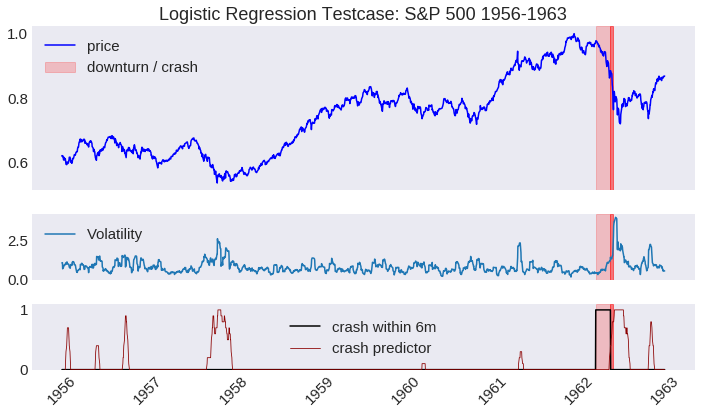

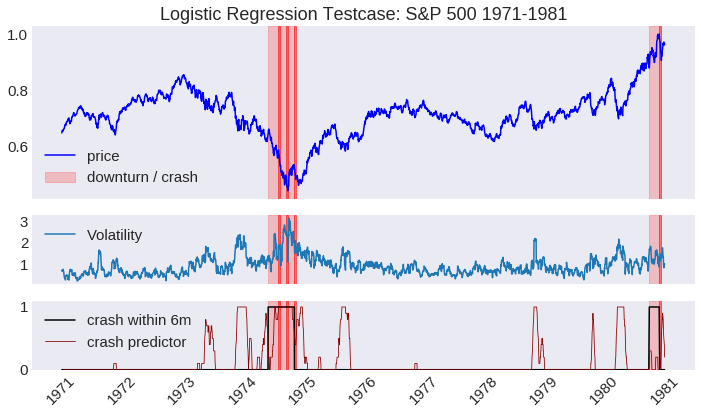

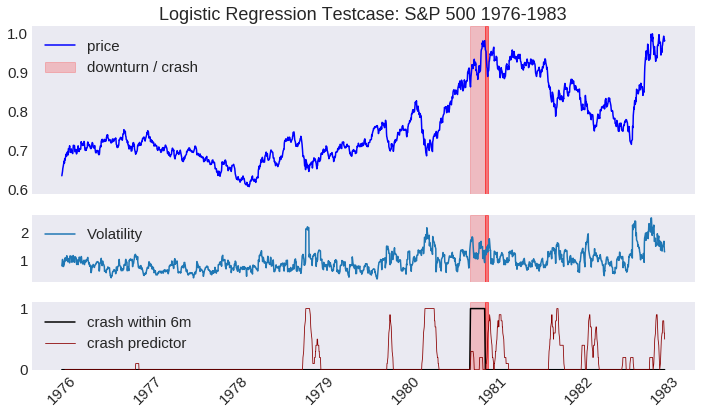

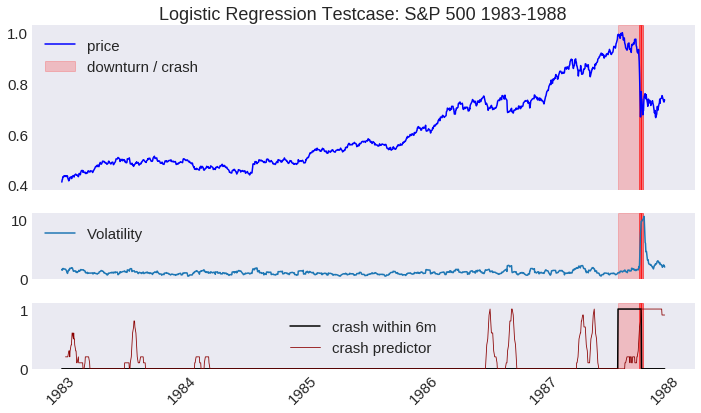

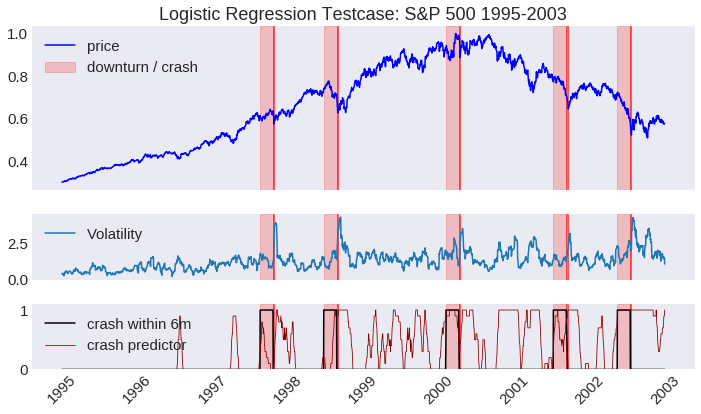

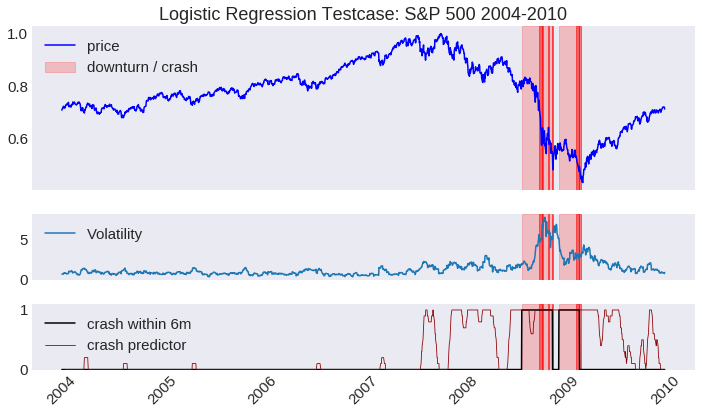

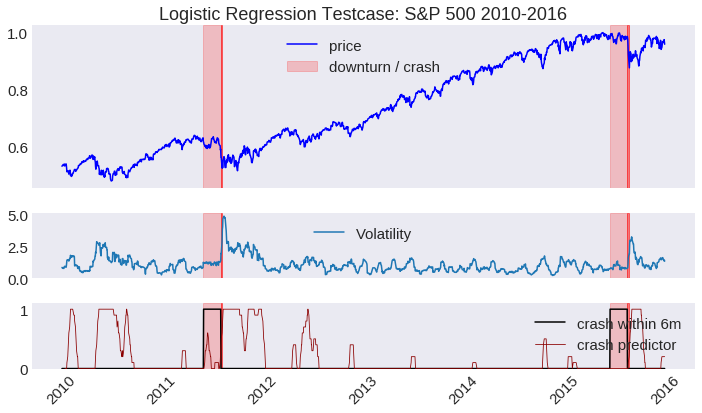

In [10]:
# -------------------- Plot test results -------------------- #
df = datasets_revised[index_test].reindex(dfs_x[index_test].index)
df['y'] = y_test
df['y_pred'] = y_pred_test_bin
c = crashes[index_test]
t_start = ['1956-01-01', '1971-01-01', '1976-01-01', '1983-01-01', '1995-01-01', '2004-01-01', '2010-01-01']
t_end = ['1963-01-01', '1981-01-01', '1983-01-01', '1988-01-01', '2003-01-01', '2010-01-01', '2016-01-01']
rcParams['figure.figsize'] = 10, 6
eval_.plot_test_results(df, c, t_start, t_end)